In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
state_dim = 64
num_actions = 25
horizon = 20

In [5]:
from a5cpu_BCQ.model import BCQ
from a5cpu_BCQ.data import remap_rewards
from a5cpu_BCQ.data import EpisodicBuffer as EpisodicBufferOO
from a7cpu_BCQf.model import BCQf
from a7cpu_BCQf.data import EpisodicBuffer as EpisodicBufferFF
from a7cpu_BCQf.model import all_subactions_vec

In [6]:
from evaluate import (
    EpisodicBufferO, offline_evaluation_O,
    EpisodicBufferF, offline_evaluation_F,
)

In [7]:
from types import SimpleNamespace
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

In [8]:
df_1_best = pd.read_csv('best_BCQ_meta.csv')
df_2_best = pd.read_csv('best_BCQf_meta.csv')

In [9]:
df_1_best

,index,iteration,val_qvalues,val_wis,val_ess,epoch,created_at,version,threshold,seed
0,97,9800.0,11.247806,92.497391,202.913132,5,2021-11-15 19:47:41.309691,17,0.5,1


In [10]:
df_2_best

,index,iteration,val_qvalues,val_wis,val_ess,epoch,created_at,version,threshold,seed
0,90,9100.0,10.518903,93.28846,216.866272,5,2021-11-15 19:51:43.311177,27,0.5,4


In [11]:
df_1_best['version'].item()

17

In [12]:
model_1 = BCQ.load_from_checkpoint(
    checkpoint_path=f'../a5cpu_BCQ/logs/mimic_dBCQ/version_{df_1_best["version"].item()}/checkpoints/step={int(df_1_best["iteration"].item()-1)}.ckpt', 
    map_location=None)
model_1.eval()

model_2 = BCQf.load_from_checkpoint(
    checkpoint_path=f'../a7cpu_BCQf/logs/mimic_dBCQf/version_{df_2_best["version"].item()}/checkpoints/step={int(df_2_best["iteration"].item()-1)}.ckpt', 
    map_location=None)
model_2.eval()
model_2.all_subactions_vec = all_subactions_vec

In [13]:
test_episodes_O = EpisodicBufferO(state_dim, num_actions, horizon)
test_episodes_O.load('../data/episodes+encoded_state+knn_pibs/test_data.pt')
test_episodes_O.reward = remap_rewards(test_episodes_O.reward, SimpleNamespace(**{'R_immed': 0.0, 'R_death': 0.0, 'R_disch': 100.0}))

tmp_test_episodes_loader_O = DataLoader(test_episodes_O, batch_size=len(test_episodes_O), shuffle=False)
test_batch_O = next(iter(tmp_test_episodes_loader_O))

Episodic Buffer loaded with 2894 episides.


In [14]:
test_wis_1, test_ess_1 = model_1.offline_evaluation(test_batch_O, weighted=True, eps=0.01)
test_wis_2, test_ess_2 = offline_evaluation_O(model_2, test_batch_O, weighted=True, eps=0.01)

In [15]:
print(f'Observed Test \t WIS: {test_episodes_O.reward.sum(axis=1).mean():.2f} \t ESS: {test_episodes_O.reward.shape[0]:.2f}')
print(f'Baseline BCQ \t WIS: {test_wis_1:.2f} \t ESS: {test_ess_1:.2f}')
print(f'Factored BCQ \t WIS: {test_wis_2:.2f} \t ESS: {test_ess_2:.2f}')

Observed Test 	 WIS: 90.29 	 ESS: 2894.00
Baseline BCQ 	 WIS: 90.44 	 ESS: 178.32
Factored BCQ 	 WIS: 91.62 	 ESS: 178.32


In [16]:
states, actions, rewards, not_dones, pibs, estm_pibs = test_batch_O
n, horizon, _ = states.shape

action_obs = []
for idx in tqdm(range(n)):
    lng = (not_dones[idx, :, 0].sum() + 1).item()  # all but the final transition has notdone==1

#     # Predict Q-values and Imitation probabilities
#     q, imt, _ = model_1.Q(states[idx])
#     imt = imt.exp()
#     imt = (imt / imt.max(1, keepdim=True).values > model_1.threshold).float()

    # Use large negative number to mask actions from argmax
    a_id = actions[idx, :, 0].cpu().numpy()
    a_id[lng:] = -1
    action_obs.append(a_id)

100%|██████████| 2894/2894 [00:00<00:00, 37996.00it/s]


In [17]:
action_obs = np.array(action_obs)

In [18]:
action_obs

array([[ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       ...,
       [10, 10,  5, ..., -1, -1, -1],
       [12,  7,  7, ...,  7,  7, -1],
       [ 5,  5,  5, ...,  5,  5, -1]])

In [19]:
df_action_obs = pd.DataFrame(action_obs.flatten(), columns=['a:action'])

In [20]:
df_state_action_obs = pd.DataFrame(action_obs.flatten(), columns=['a:action'])
df_state_action_obs[[f's:{d}' for d in range(64)]] = states.reshape((-1, 64))
df_state_action_obs = df_state_action_obs[df_state_action_obs['a:action'] != -1]

In [21]:
df_state_action_obs

,a:action,s:0,s:1,s:2,s:3,s:4,s:5,s:6,s:7,s:8,...,s:54,s:55,s:56,s:57,s:58,s:59,s:60,s:61,s:62,s:63
0,0,0.269461,-0.405183,-0.073669,0.237098,0.131069,-0.015725,0.297743,0.425289,-0.136253,...,0.298927,0.139896,0.089612,-0.276677,-0.153097,-0.412756,-0.050796,0.242759,0.062217,-0.200472
1,0,0.128267,-0.554217,-0.005621,0.349326,0.088218,0.041929,0.440411,0.506251,-0.166264,...,0.412430,0.137813,0.168073,-0.368494,-0.224553,-0.462398,-0.141981,0.189483,0.228359,-0.293396
2,0,0.099390,-0.642853,0.127591,0.381555,-0.026234,0.154912,0.250158,0.464318,-0.083545,...,0.427649,0.122746,0.091960,-0.380721,-0.342279,-0.372929,-0.277801,0.150786,0.261166,-0.369172
3,0,-0.033160,-0.667075,0.039772,0.431048,0.021953,0.077217,0.181416,0.531199,-0.102749,...,0.498768,0.231783,-0.071976,-0.405995,-0.446772,-0.455835,-0.265563,0.124215,0.381844,-0.379337
4,0,-0.008037,-0.743795,0.082937,0.484527,0.029545,0.060907,0.265568,0.524239,-0.004020,...,0.505898,0.261947,-0.146223,-0.429408,-0.509647,-0.329061,-0.258404,0.035153,0.317253,-0.383649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57874,10,0.364733,-0.430284,-0.162231,0.266972,-0.033441,0.179400,-0.099619,0.467415,0.226725,...,0.571488,0.207231,0.137958,0.042470,-0.205400,-0.413355,-0.217783,-0.073419,-0.123248,-0.357599
57875,5,0.373027,-0.473815,-0.186167,0.262891,-0.012453,0.137106,-0.081776,0.474162,0.220291,...,0.586924,0.263147,0.124830,0.032427,-0.256024,-0.436276,-0.206038,-0.056162,-0.097101,-0.342389
57876,5,0.283446,-0.421932,-0.145377,0.272160,0.035856,0.240214,-0.164696,0.363078,0.194447,...,0.508160,0.197045,0.212223,-0.259360,-0.294120,-0.412895,-0.226019,-0.116027,-0.072876,-0.343136
57877,5,0.232918,-0.406742,-0.127288,0.233639,0.054578,0.194464,-0.178343,0.479095,0.180291,...,0.463935,0.248197,0.220753,-0.124796,-0.177910,-0.396238,-0.200657,-0.055311,-0.085051,-0.348760


In [22]:
df_expected_std = []
for a in range(25):
    df_a = df_state_action_obs[df_state_action_obs['a:action'] == a].drop(columns=['a:action'])
    df_expected_std.append([a, df_a.std().mean()])

df_expected_std = pd.DataFrame(df_expected_std, columns=['a:action', 'expected_std'])

In [23]:
df_expected_std

,a:action,expected_std
0,0,0.151704
1,1,0.155792
2,2,0.138589
3,3,0.144178
4,4,0.157282
5,5,0.154186
6,6,0.158462
7,7,0.160910
8,8,0.164787
9,9,0.175848


In [24]:
df_state_action_obs = pd.DataFrame(action_obs.flatten(), columns=['a:action'])
df_state_action_obs[[f's:{d}' for d in range(64)]] = states.reshape((-1, 64))
df_state_action_obs = df_state_action_obs[df_state_action_obs['a:action'] != -1].copy()

In [25]:
df_state_action_obs['a:vaso'] = df_state_action_obs['a:action'] % 5
df_state_action_obs['a:iv'] = df_state_action_obs['a:action'] // 5

In [26]:
df_state_action_obs

,a:action,s:0,s:1,s:2,s:3,s:4,s:5,s:6,s:7,s:8,...,s:56,s:57,s:58,s:59,s:60,s:61,s:62,s:63,a:vaso,a:iv
0,0,0.269461,-0.405183,-0.073669,0.237098,0.131069,-0.015725,0.297743,0.425289,-0.136253,...,0.089612,-0.276677,-0.153097,-0.412756,-0.050796,0.242759,0.062217,-0.200472,0,0
1,0,0.128267,-0.554217,-0.005621,0.349326,0.088218,0.041929,0.440411,0.506251,-0.166264,...,0.168073,-0.368494,-0.224553,-0.462398,-0.141981,0.189483,0.228359,-0.293396,0,0
2,0,0.099390,-0.642853,0.127591,0.381555,-0.026234,0.154912,0.250158,0.464318,-0.083545,...,0.091960,-0.380721,-0.342279,-0.372929,-0.277801,0.150786,0.261166,-0.369172,0,0
3,0,-0.033160,-0.667075,0.039772,0.431048,0.021953,0.077217,0.181416,0.531199,-0.102749,...,-0.071976,-0.405995,-0.446772,-0.455835,-0.265563,0.124215,0.381844,-0.379337,0,0
4,0,-0.008037,-0.743795,0.082937,0.484527,0.029545,0.060907,0.265568,0.524239,-0.004020,...,-0.146223,-0.429408,-0.509647,-0.329061,-0.258404,0.035153,0.317253,-0.383649,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57874,10,0.364733,-0.430284,-0.162231,0.266972,-0.033441,0.179400,-0.099619,0.467415,0.226725,...,0.137958,0.042470,-0.205400,-0.413355,-0.217783,-0.073419,-0.123248,-0.357599,0,2
57875,5,0.373027,-0.473815,-0.186167,0.262891,-0.012453,0.137106,-0.081776,0.474162,0.220291,...,0.124830,0.032427,-0.256024,-0.436276,-0.206038,-0.056162,-0.097101,-0.342389,0,1
57876,5,0.283446,-0.421932,-0.145377,0.272160,0.035856,0.240214,-0.164696,0.363078,0.194447,...,0.212223,-0.259360,-0.294120,-0.412895,-0.226019,-0.116027,-0.072876,-0.343136,0,1
57877,5,0.232918,-0.406742,-0.127288,0.233639,0.054578,0.194464,-0.178343,0.479095,0.180291,...,0.220753,-0.124796,-0.177910,-0.396238,-0.200657,-0.055311,-0.085051,-0.348760,0,1


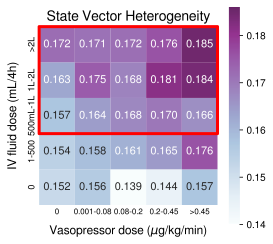

In [28]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(df_expected_std.set_index('a:action').values.reshape((5,5)), 
            ax=ax, square=True, cmap="BuPu", alpha=0.85, vmin=0.14, vmax=0.186, annot=True, fmt='.3f', annot_kws={"size": 11})
ax.invert_yaxis()

plt.title('State Vector Heterogeneity', fontsize=14)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Vasopressor dose ($\mu$g/kg/min)", fontsize=12)
plt.ylabel("IV fluid dose (mL/4h)", fontsize=12)

xranges = ['0', '0.001-0.08', '0.08-0.2', '0.2-0.45', '>0.45']
yranges = ['0', '1-500', '500mL-1L', '1L-2L', '>2L']
for pos, text in enumerate(xranges):
    plt.text(pos+3/6, -0.2, text, fontsize=8, ha='center', va='center')
for pos, text in enumerate(yranges):
    plt.text(-0.2, pos+3/6, text, fontsize=9, ha='center', va='center', rotation='vertical')

plt.gca().add_patch(
    matplotlib.patches.Rectangle((0, 2), 5, 3, edgecolor='red', facecolor='none', lw=3, clip_on=False)
)

plt.savefig('./fig/mimic_test_heterogeneity_clinician.pdf', bbox_inches='tight')
plt.show()

In [99]:
df_iv_expected_std = []
for a_iv in range(5):
    df_a = df_state_action_obs[df_state_action_obs['a:iv'] == a_iv].drop(columns=['a:action', 'a:iv', 'a:vaso'])
    df_iv_expected_std.append([a_iv, df_a.std().mean()])

df_iv_expected_std = pd.DataFrame(df_iv_expected_std, columns=['a:iv', 'expected_std'])

In [104]:
df_vaso_expected_std = []
for a_vaso in range(5):
    df_a = df_state_action_obs[df_state_action_obs['a:vaso'] == a_vaso].drop(columns=['a:action', 'a:iv', 'a:vaso'])
    df_vaso_expected_std.append([a_vaso, df_a.std().mean()])

df_vaso_expected_std = pd.DataFrame(df_vaso_expected_std, columns=['a:vaso', 'expected_std'])

In [101]:
df_iv_expected_std

,a:iv,expected_std
0,0,0.151951
1,1,0.156664
2,2,0.160810
3,3,0.170025
4,4,0.177201


In [105]:
df_vaso_expected_std

,a:vaso,expected_std
0,0,0.155558
1,1,0.162365
2,2,0.164676
3,3,0.170200
4,4,0.178248


In [107]:
np.block([
    [np.nan, df_vaso_expected_std.set_index('a:vaso').values.reshape((1,5))], 
    [df_iv_expected_std.set_index('a:iv').values.reshape((5,1)), df_expected_std.set_index('a:action').values.reshape((5,5))]])

array([[       nan, 0.15555763, 0.16236542, 0.16467588, 0.17020017,
        0.17824758],
       [0.15195099, 0.1517035 , 0.15579154, 0.13858873, 0.14417779,
        0.15728247],
       [0.15666434, 0.15418576, 0.15846237, 0.16090983, 0.16478682,
        0.17584777],
       [0.16081032, 0.1573345 , 0.16431576, 0.16755416, 0.17027002,
        0.16645015],
       [0.17002455, 0.16269425, 0.17466613, 0.16834197, 0.18147151,
        0.18398707],
       [0.17720143, 0.17194175, 0.17095653, 0.17159499, 0.17588378,
        0.18484681]])

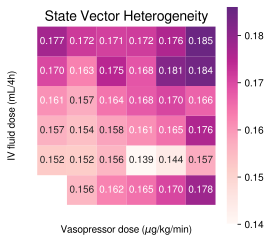

In [108]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(
    np.block([
    [np.nan, df_vaso_expected_std.set_index('a:vaso').values.reshape((1,5))], 
    [df_iv_expected_std.set_index('a:iv').values.reshape((5,1)), df_expected_std.set_index('a:action').values.reshape((5,5))]]), 
    ax=ax, square=True, cmap="RdPu", alpha=0.85, vmin=0.14, vmax=0.186, annot=True, fmt='.3f'
)
ax.invert_yaxis()

plt.title('State Vector Heterogeneity', fontsize=14)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Vasopressor dose ($\mu$g/kg/min)")
plt.ylabel("IV fluid dose (mL/4h)")

# xranges = ['0', '0.001-0.08', '0.08-0.2', '0.2-0.45', '>0.45']
# yranges = ['0', '1-500', '500mL-1L', '1L-2L', '>2L']
# for pos, text in enumerate(xranges):
#     plt.text(pos+3/6, -0.2, text, fontsize=7, ha='center', va='center')
# for pos, text in enumerate(yranges):
#     plt.text(-0.2, pos+3/6, text, fontsize=7, ha='center', va='center', rotation='vertical')

# plt.savefig('./fig/mimic_test_heterogeneity_clinician.pdf', bbox_inches='tight')
plt.show()